<a href="https://colab.research.google.com/github/itzsandip007/data-science-learning/blob/main/day5_sql_analytics_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Cell 1 — setup
!pip install -q duckdb
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("DuckDB version:", duckdb.__version__)


DuckDB version: 1.3.2


In [10]:
# Cell 2 — create sample tables as pandas DataFrames
customers = pd.DataFrame([
    {'CustomerID': 1, 'CustomerName': 'Amit', 'Country': 'India'},
    {'CustomerID': 2, 'CustomerName': 'Ravi', 'Country': 'India'},
    {'CustomerID': 3, 'CustomerName': 'Sana', 'Country': 'India'},
    {'CustomerID': 4, 'CustomerName': 'Mona', 'Country': 'USA'},
    {'CustomerID': 5, 'CustomerName': 'Arjun', 'Country': 'India'},
])

orders = pd.DataFrame([
    {'OrderID': 101, 'CustomerID': 1, 'OrderDate': '2024-11-01'},
    {'OrderID': 102, 'CustomerID': 2, 'OrderDate': '2024-11-10'},
    {'OrderID': 103, 'CustomerID': 1, 'OrderDate': '2024-12-01'},
    {'OrderID': 104, 'CustomerID': 4, 'OrderDate': '2024-10-20'},
    {'OrderID': 105, 'CustomerID': 2, 'OrderDate': '2024-12-05'},
    # note: CustomerID 3 and 5 may have no orders (to test "no orders")
])

order_details = pd.DataFrame([
    {'OrderID': 101, 'ProductID': 11, 'Quantity': 2, 'Price': 500},
    {'OrderID': 101, 'ProductID': 12, 'Quantity': 1, 'Price': 1200},
    {'OrderID': 102, 'ProductID': 11, 'Quantity': 1, 'Price': 500},
    {'OrderID': 103, 'ProductID': 13, 'Quantity': 5, 'Price': 200},
    {'OrderID': 104, 'ProductID': 12, 'Quantity': 2, 'Price': 1200},
    {'OrderID': 105, 'ProductID': 14, 'Quantity': 3, 'Price': 150},
])

# Show quick preview
customers.head(), orders.head(), order_details.head()


(   CustomerID CustomerName Country
 0           1         Amit   India
 1           2         Ravi   India
 2           3         Sana   India
 3           4         Mona     USA
 4           5        Arjun   India,
    OrderID  CustomerID   OrderDate
 0      101           1  2024-11-01
 1      102           2  2024-11-10
 2      103           1  2024-12-01
 3      104           4  2024-10-20
 4      105           2  2024-12-05,
    OrderID  ProductID  Quantity  Price
 0      101         11         2    500
 1      101         12         1   1200
 2      102         11         1    500
 3      103         13         5    200
 4      104         12         2   1200)

In [11]:
# Cell 3 — register pandas DataFrames as SQL tables in DuckDB session
duckdb.register('customers', customers)
duckdb.register('orders', orders)
duckdb.register('order_details', order_details)

# Quick check: list first few rows via SQL
duckdb.query("SELECT * FROM customers").df()


,CustomerID,CustomerName,Country
0,1,Amit,India
1,2,Ravi,India
2,3,Sana,India
3,4,Mona,USA
4,5,Arjun,India


In [12]:
# Cell 4 — order total per OrderID
q1 = """
SELECT od.OrderID,
       SUM(od.Quantity * od.Price) AS order_total
FROM order_details od
GROUP BY od.OrderID
ORDER BY od.OrderID;
"""
order_totals = duckdb.query(q1).df()
order_totals


,OrderID,order_total
0,101,2200.0
1,102,500.0
2,103,1000.0
3,104,2400.0
4,105,450.0


In [13]:
# Cell 5 — total & avg spending per customer
q2 = """
WITH order_totals AS (
  SELECT od.OrderID, SUM(od.Quantity * od.Price) AS order_total
  FROM order_details od
  GROUP BY od.OrderID
)
SELECT c.CustomerID, c.CustomerName,
       COUNT(o.OrderID) AS num_orders,
       COALESCE(SUM(ot.order_total),0) AS total_spent,
       COALESCE(AVG(ot.order_total),0) AS avg_order_value
FROM customers c
LEFT JOIN orders o ON c.CustomerID = o.CustomerID
LEFT JOIN order_totals ot ON o.OrderID = ot.OrderID
GROUP BY c.CustomerID, c.CustomerName
ORDER BY total_spent DESC;
"""
cust_spend = duckdb.query(q2).df()
cust_spend


,CustomerID,CustomerName,num_orders,total_spent,avg_order_value
0,1,Amit,2,3200.0,1600.0
1,4,Mona,1,2400.0,2400.0
2,2,Ravi,2,950.0,475.0
3,3,Sana,0,0.0,0.0
4,5,Arjun,0,0.0,0.0


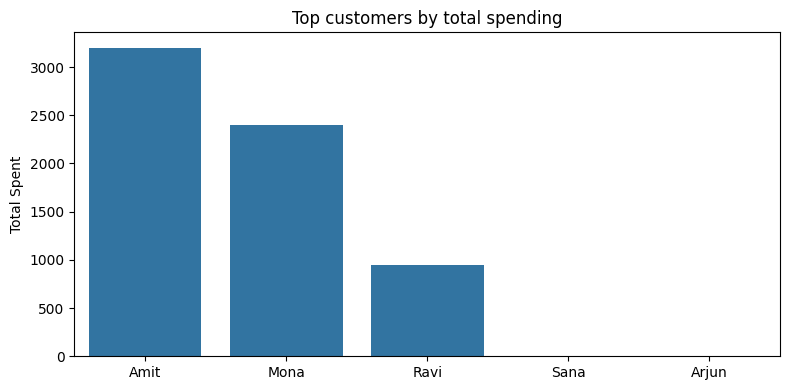

In [14]:
# Cell 6 — top customers visualization (top 5)
top_cust = cust_spend.sort_values('total_spent', ascending=False).head(10)

plt.figure(figsize=(8,4))
sns.barplot(data=top_cust, x='CustomerName', y='total_spent')
plt.title("Top customers by total spending")
plt.ylabel("Total Spent")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [15]:
q3 = """
SELECT c.customerID, C.CustomerName
FROM customers c
LEFT JOIN orders o ON c.CustomerID = o.CustomerID
where o.OrderID IS NULL;
"""
no_orders = duckdb.query(q3).df()
no_orders

,CustomerID,CustomerName
0,3,Sana
1,5,Arjun


In [19]:
q4 = """
WITH RankedOrders AS (
    SELECT
        OrderID,
        CustomerID,
        OrderDate,
        ROW_NUMBER() OVER (PARTITION BY CustomerID ORDER BY OrderDate DESC) as rn
    FROM orders
)
SELECT
    o.CustomerID,
    c.CustomerName,
    o.OrderID,
    o.OrderDate
FROM RankedOrders o
JOIN customers c ON o.CustomerID = c.CustomerID
WHERE rn = 1
ORDER BY o.CustomerID;
"""
latest_order = duckdb.query(q4).df()
latest_order

,CustomerID,CustomerName,OrderID,OrderDate
0,1,Amit,103,2024-12-01
1,2,Ravi,105,2024-12-05
2,4,Mona,104,2024-10-20


In [20]:
# Cell 9 — save key outputs to CSV files in Colab environment
order_totals.to_csv("order_totals.csv", index=False)
cust_spend.to_csv("customer_spending.csv", index=False)
no_orders.to_csv("customers_no_orders.csv", index=False)
latest_order.to_csv("latest_order_per_customer.csv", index=False)

print("Saved CSVs: order_totals.csv, customer_spending.csv, customers_no_orders.csv, latest_order_per_customer.csv")
# If using Colab: on left side Files panel you can click and download these files.
# To push to GitHub: File -> Save a copy in GitHub (or download locally and upload in your repo).


Saved CSVs: order_totals.csv, customer_spending.csv, customers_no_orders.csv, latest_order_per_customer.csv
